In [ ]:
!pip install -q  "accelerate==0.33.0" "bitsandbytes==0.43.1" "safetensors>=0.3.1"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 6.5 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-0tgmh7ym
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-0tgmh7ym
  Resolved https://github.com/huggingface/transformers.git to commit 78b2929c0554b79e0489b451ce4ece14d265ead2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.45.0.dev0-py3-none-any.whl size=9786808 sha256=4304e9916747e6defb4d2e0ab7a9d6a185bdaa8e27ed862a8914fd3f05154040
  Stored in directory: /tmp/pip-ephem-wheel-cache-zz3ioivx/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2


In [ ]:
from __future__ import annotations

import base64
import math
from io import BytesIO

import requests
import torch
from PIL import Image
from torchvision import io, transforms
from torchvision.transforms import InterpolationMode


IMAGE_FACTOR = 28
MIN_PIXELS = 4 * 28 * 28
MAX_PIXELS = 16384 * 28 * 28
MAX_RATIO = 200

VIDEO_MIN_PIXELS = 128 * 28 * 28
VIDEO_MAX_PIXELS = 768 * 28 * 28
VIDEO_TOTAL_PIXELS = 24576 * 28 * 28
FRAME_FACTOR = 2
FPS = 2.0
FPS_MIN_FRAMES = 4
FPS_MAX_FRAMES = 768


def round_by_factor(number: int, factor: int) -> int:
    """Returns the closest integer to 'number' that is divisible by 'factor'."""
    return round(number / factor) * factor


def ceil_by_factor(number: int, factor: int) -> int:
    """Returns the smallest integer greater than or equal to 'number' that is divisible by 'factor'."""
    return math.ceil(number / factor) * factor


def floor_by_factor(number: int, factor: int) -> int:
    """Returns the largest integer less than or equal to 'number' that is divisible by 'factor'."""
    return math.floor(number / factor) * factor


def smart_resize(
    height: int, width: int, factor: int = IMAGE_FACTOR, min_pixels: int = MIN_PIXELS, max_pixels: int = MAX_PIXELS
) -> tuple[int, int]:
    """
    Rescales the image so that the following conditions are met:

    1. Both dimensions (height and width) are divisible by 'factor'.

    2. The total number of pixels is within the range ['min_pixels', 'max_pixels'].

    3. The aspect ratio of the image is maintained as closely as possible.
    """
    if max(height, width) / min(height, width) > MAX_RATIO:
        raise ValueError(
            f"absolute aspect ratio must be smaller than {MAX_RATIO}, got {max(height, width) / min(height, width)}"
        )
    h_bar = max(factor, round_by_factor(height, factor))
    w_bar = max(factor, round_by_factor(width, factor))
    if h_bar * w_bar > max_pixels:
        beta = math.sqrt((height * width) / max_pixels)
        h_bar = floor_by_factor(height / beta, factor)
        w_bar = floor_by_factor(width / beta, factor)
    elif h_bar * w_bar < min_pixels:
        beta = math.sqrt(min_pixels / (height * width))
        h_bar = ceil_by_factor(height * beta, factor)
        w_bar = ceil_by_factor(width * beta, factor)
    return h_bar, w_bar


def fetch_image(ele: dict[str, str | Image.Image], size_factor: int = IMAGE_FACTOR) -> Image.Image:
    if "image" in ele:
        image = ele["image"]
    else:
        image = ele["image_url"]
    image_obj = None
    if isinstance(image, Image.Image):
        image_obj = image
    elif image.startswith("http://") or image.startswith("https://"):
        image_obj = Image.open(requests.get(image, stream=True).raw)
    elif image.startswith("file://"):
        image_obj = Image.open(image[7:])
    elif image.startswith("data:image"):
        if "base64," in image:
            _, base64_data = image.split("base64,", 1)
            data = base64.b64decode(base64_data)
            image_obj = Image.open(BytesIO(data))
    else:
        image_obj = Image.open(image)
    if image_obj is None:
        raise ValueError(f"Unrecognized image input, support local path, http url, base64 and PIL.Image, got {image}")
    image = image_obj.convert("RGB")
    ## resize
    if "resized_height" in ele and "resized_width" in ele:
        resized_height, resized_width = smart_resize(
            ele["resized_height"],
            ele["resized_width"],
            factor=size_factor,
        )
    else:
        width, height = image.size
        min_pixels = ele.get("min_pixels", MIN_PIXELS)
        max_pixels = ele.get("max_pixels", MAX_PIXELS)
        resized_height, resized_width = smart_resize(
            height,
            width,
            factor=size_factor,
            min_pixels=min_pixels,
            max_pixels=max_pixels,
        )
    image = image.resize((resized_width, resized_height))

    return image


def fetch_video(ele: dict, image_factor: int = IMAGE_FACTOR) -> torch.Tensor | list[Image.Image]:
    if isinstance(ele["video"], str):
        # TODO: support http url

        video = ele["video"]
        if video.startswith("file://"):
            video = video[7:]

        video, audio, info = io.read_video(
            video,
            start_pts=ele.get("video_start", 0.0),
            end_pts=ele.get("video_end", None),
            pts_unit="sec",
            output_format="TCHW",
        )

        assert not ("fps" in ele and "nframes" in ele), "Only accept either `fps` or `nframes`"
        if "nframes" in ele:
            nframes = round_by_factor(ele["nframes"], FRAME_FACTOR)
        else:
            fps = ele.get("fps", FPS)
            min_frames = ceil_by_factor(ele.get("min_frames", FPS_MIN_FRAMES), FRAME_FACTOR)
            max_frames = floor_by_factor(ele.get("max_frames", min(FPS_MAX_FRAMES, video.size(0))), FRAME_FACTOR)
            nframes = video.size(0) / info["video_fps"] * fps
            nframes = min(max(nframes, min_frames), max_frames)
            nframes = round_by_factor(nframes, FRAME_FACTOR)
        if not (FRAME_FACTOR <= nframes and nframes <= video.size(0)):
            raise ValueError(f"nframes should in interval [{FRAME_FACTOR}, {video.size(0)}], but got {nframes}.")

        idx = torch.linspace(0, video.size(0) - 1, nframes).round().long()
        height, width = video.shape[2:]
        video = video[idx]

        min_pixels = ele.get("min_pixels", VIDEO_MIN_PIXELS)
        total_pixels = ele.get("total_pixels", VIDEO_TOTAL_PIXELS)
        max_pixels = max(min(VIDEO_MAX_PIXELS, total_pixels / nframes * FRAME_FACTOR), int(min_pixels * 1.05))
        max_pixels = ele.get("max_pixels", max_pixels)
        if "resized_height" in ele and "resized_width" in ele:
            resized_height, resized_width = smart_resize(
                ele["resized_height"],
                ele["resized_width"],
                factor=image_factor,
            )
        else:
            resized_height, resized_width = smart_resize(
                height,
                width,
                factor=image_factor,
                min_pixels=min_pixels,
                max_pixels=max_pixels,
            )
        video = transforms.functional.resize(
            video,
            [resized_height, resized_width],
            interpolation=InterpolationMode.BICUBIC,
            antialias=True,
        ).float()
        return video
    else:
        assert isinstance(ele["video"], (list, tuple))
        process_info = ele.copy()
        process_info.pop("type", None)
        process_info.pop("video", None)
        images = [
            fetch_image({"image": video_element, **process_info}, size_factor=image_factor)
            for video_element in ele["video"]
        ]
        nframes = ceil_by_factor(len(images), FRAME_FACTOR)
        if len(images) < nframes:
            images.extend([images[-1]] * (nframes - len(images)))
        return images


def extract_vision_info(conversations: list[dict] | list[list[dict]]) -> list[dict]:
    vision_infos = []
    if isinstance(conversations[0], dict):
        conversations = [conversations]
    for conversation in conversations:
        for message in conversation:
            if isinstance(message["content"], list):
                for ele in message["content"]:
                    if (
                        "image" in ele
                        or "image_url" in ele
                        or "video" in ele
                        or ele["type"] in ("image", "image_url", "video")
                    ):
                        vision_infos.append(ele)
    return vision_infos


def process_vision_info(
    conversations: list[dict] | list[list[dict]],
) -> tuple[list[Image.Image] | None, list[torch.Tensor | list[Image.Image]] | None]:
    vision_infos = extract_vision_info(conversations)
    ## Read images or videos
    image_inputs = []
    video_inputs = []
    for vision_info in vision_infos:
        if "image" in vision_info or "image_url" in vision_info:
            image_inputs.append(fetch_image(vision_info))
        elif "video" in vision_info:
            video_inputs.append(fetch_video(vision_info))
        else:
            raise ValueError("image, image_url or video should in content.")
    if len(image_inputs) == 0:
        image_inputs = None
    if len(video_inputs) == 0:
        video_inputs = None
    return image_inputs, video_inputs


In [ ]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
import torch

model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    torch_dtype=torch.float16,
    device_map="auto"
)

processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

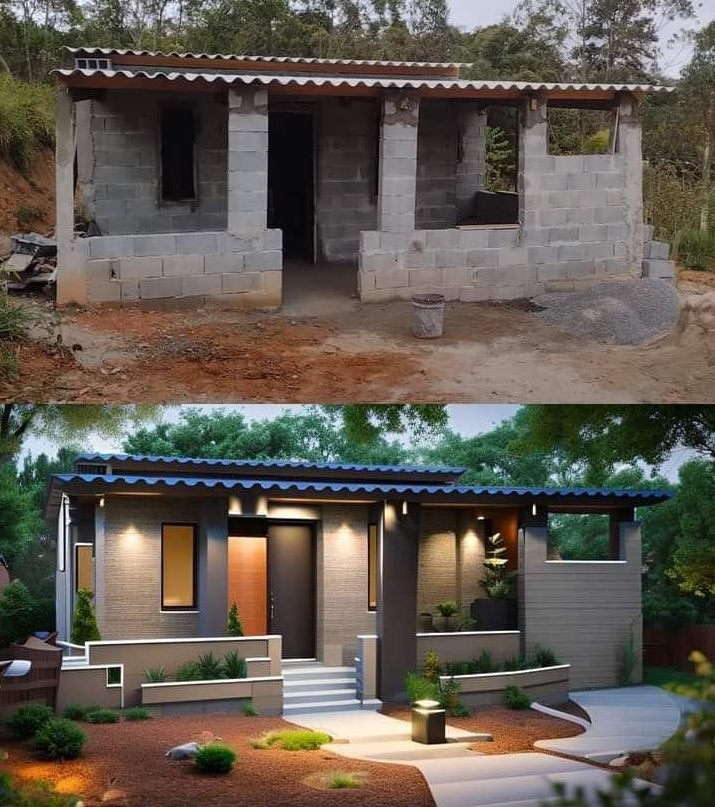

In [ ]:
from PIL import Image

img = Image.open('/content/house.png')
img

In [ ]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": "/content/house.png"},
            {"type": "text", "text": "can you details the house interior design of rooms and halls"},
        ],
    }
]

In [ ]:
# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

image_inputs, video_inputs = process_vision_info(messages)

inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

In [ ]:
print(text)

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>can you details the house interior design of rooms and halls<|im_end|>
<|im_start|>assistant



In [ ]:
# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=512)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text[0])

The image shows a before-and-after comparison of a house's exterior and interior design. Here are the details of the house's interior design:

### Before:
- **Exterior**: The house is made of concrete blocks and has a corrugated metal roof.
- **Interior**: The house appears to be in the early stages of construction, with the walls still in the process of being built. There are visible gaps and unfinished areas.

### After:
- **Exterior**: The house has been completed and is now a modern, two-story structure. The walls are finished, and the roof has been installed.
- **Interior**: The interior has been transformed into a modern, open-plan living space. The walls are painted in a neutral color, and there are large windows and doors that allow natural light to flood the space. The flooring is also modern, with a combination of wood and tiles. There are also plants and small garden features added to the exterior, enhancing the aesthetic appeal.

### Design Elements:
- **Windows**: There ar